In [ ]:
#import matplotlib as mpl
#from statsmodels.tsa.stattools import acf, pacf

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as st
import pingouin as pg
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython.display import Image

# 11.1 Correlación cruzada

Todos los capítulos anteriores han analizado el análisis de grupos de datos donde la secuencia de los datos era irrelevante. 

Sin embargo, para muchas cantidades de la vida real, la secuencia es crucial. 

Ej: en medicina, geología y econometría, el momento de los acontecimientos marca una gran diferencia: venda sus acciones un día antes y es posible que haya pasado de millonario a pobre. 

Se describen diferentes aspectos de la búsqueda de patrones en las señales. 

Descripción de la correlación cruzada: se observa la ocurrencia de una característica más corta en una señal más larga. 

Casos especiales:
- Cuando las 2 señales tienen la misma longitud, uno puede preguntarse qué tan fuerte es la relación lineal entre las 2 variables. 
    - Esta comparación de señales requiere una normalización para eliminar artefactos triviales y conduce a la definición del coeficiente de correlación. 
    - Para datos multivariados, se explica la generalización del coeficiente de correlación a la matriz de correlación. 
    - Se obtiene una interpretación intuitiva del coeficiente de correlación al observar cómo se relaciona con el mejor ajuste de línea para las dos variables. 
    - El cuadrado del coeficiente de correlación, el coeficiente de determinación, cuantifica qué parte del cambio de señal en una variable se explica por el cambio correspondiente en la otra variable. 
    
- Comparando una señal con versiones modificadas de sí misma.
    - Se denomina autocorrelación y se puede utilizar para encontrar patrones sistemáticos ocultos en las señales. 

Es una medida de similitud de dos series en función del desplazamiento de una con respecto a la otra. 

Se conoce como producto de punto deslizante o producto interno deslizante. 

Se usa para buscar una señal larga para una característica conocida más corta. 

Es de naturaleza similar a la convolución de dos funciones: la única diferencia es que el orden de la segunda señal ("característica") está invertido.

Consideremos cómo podríamos evaluar la similitud de dos señales, que llamamos aquí señal y característica.

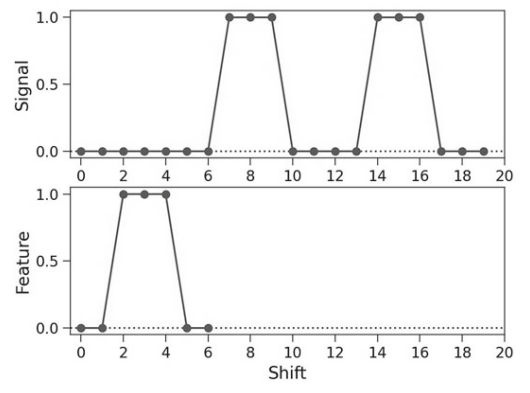

In [2]:
Image(filename = r'Imagenes/10.1.png')

Para encontrar similitudes necesitamos algún tipo de "función de similitud" tal que la función tenga un máximo cuando la característica coincida con la señal, y que disminuya a medida que aumenta la diferencia entre la señal y la característica. 

Se puede demostrar que el producto escalar satisface ambas propiedades. 

Todo lo que necesitamos hacer para comparar parte de la señal con las características es multiplicar esa parte de la señal con la característica.

Si queremos averiguar cuánto debe cambiarse la función para que coincida con la señal, calculamos la similitud para diferentes cambios relativos y elegimos el cambio con la máxima similitud.

In [ ]:
def corr_vis(x:np.ndarray, y:np.ndarray) -> None:
    """Visualize correlation, by calculating the cross-correlation of two
    signals, one point at a time. The aligned signals and the resulting corss
    correlation value are shown, and advanced when the user hits a key or
    clicks with the mouse.

    Parameters
    ----------
        X : Comparison signal
        Y : Reference signal

    Example
    -------
    x = np.r_[0:2*pi:10j]
    y = sin(x)
    corr_vis(y,x)

    Notes
    -----
    Based on an idea from dpwe@ee.columbia.edu
    """

    Nx = x.size
    Ny = y.size
    Nr = Nx + Ny -1

    xmin = -(Nx - 1)
    xmax = Ny + Nx -1

    # Generate figure and axes
    if not 'fig' in locals():
        fig, axs = plt.subplots(3,1)

    # First plot: Signal 1
    axs[0].plot(range(Ny), y, '-',  label='signal')
    ax = axs[0].axis()
    axs[0].axis([xmin, xmax, ax[2], ax[3]])
    axs[0].xaxis.grid(True)
    axs[0].set_xticklabels(())
    axs[0].set_ylabel('Y[n]')
    axs[0].legend()

    # Pre-calculate limits of correlation output
    axr = [xmin, xmax, np.correlate(x,y,'full').min(),
           np.correlate(x,y,'full').max()]

    # Make a version of y padded to the full extent of X's we'll shift
    padY = np.r_[np.zeros(Nx-1), y, np.zeros(Nx-1)]
    Npad = padY.size
    R = []

    # Generate the cross-correlation, step-by-step
    for p in range(Nr):

        # Figure aligned X
        axs[1].cla()
        axs[1].plot(np.arange(Nx)-Nx+p+1, x, '--', label='feature')

        ax = axs[1].axis()
        axs[1].axis([xmin, xmax, ax[2], ax[3]])
        axs[1].xaxis.grid(True)
        axs[1].set_ylabel('X[n-m]')
        axs[1].set_xticklabels(())
        axs[1].legend()

        # Calculate correlation
        # Pad an X to the appropriate place
        padX = np.r_[np.zeros(p), x, np.zeros(Npad-Nx-p)]
        R = np.r_[R, np.sum(padX * padY)]

        # Third plot: cross-correlation values
        axs[2].cla()
        axs[2].plot(np.arange(len(R))-(Nx-1), R,
                    'o-', linewidth=2, color='C1',
                    label='cross-correlation')
        axs[2].axis(axr)
        axs[2].grid(True)
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('$R_{xy}[m]$')
        axs[2].legend()

        # Update the plot
        plt.draw()

        # If one exits early, the command "waitforbuttonpress" crashes, and must
        # be caught. Otherwise it produces the error-message
        # _tkinter.TclError: can't invoke "update" command: application has
        #                                                       been destroyed
        try:
            plt.waitforbuttonpress()
        except:
            print('you returned before it was over :(')
            # return

    # For a printout:
    # out_file = 'corr_vis3.jpg'
    # pil_kwargs = {'quality': 95}
    # plt.savefig(out_file, dpi=300, pil_kwargs=pil_kwargs)
    # print(f'Corr-vis saved to {out_file}')

    plt.show()


if __name__ == '__main__':
    sns.set_style('ticks')

    # Generate the data used in the book
    signal = np.zeros(20)
    signal[7:10] = 1
    signal[14:17] = 1

    feature = np.zeros(7)
    feature[2:5] = 1

    corr_vis(feature, signal)

C:\Users\usuario\AppData\Local\Temp\ipykernel_12272\371769065.py:90: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.waitforbuttonpress()


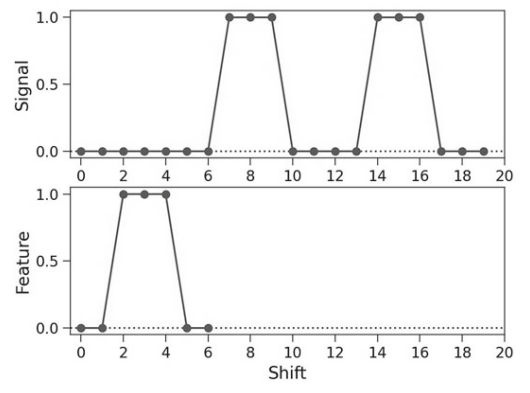

In [4]:
Image(filename = r'Imagenes/10.1.png')

En la posición inicial el producto escalar entre la señal y la característica es cero. 
- Un cambio de la característica de 5 a 12 pasos produce la superposición máxima. 
- Con superposición máxima, el producto escalar entre la señal y la característica es 3. 
- La característica se puede desplazar seis puntos hacia la izquierda, antes de que quede “fuera de rango”.

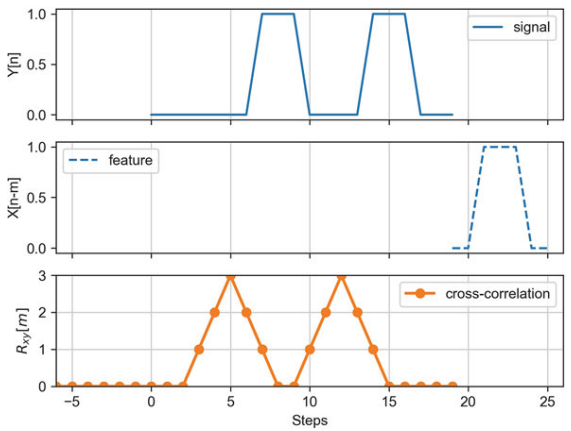

In [5]:
Image(filename = r'Imagenes/11.2.png')

Para multiplicaciones con elementos fuera del rango de señal/característica dado (punto 20), los datos faltantes correspondientes se reemplazan por ceros. 

|0|0|2|1|4|3|0|0| |
|---|---|---|---|---|---|---|---|---|
|1|3|2| | | | | | 2 ·2 = 4|
| |1|3|2| | | | | 2 · 3 + 1 · 2 = 8|
| | |1|3|2| | | | 2 · 1 + 1 · 3 + 4 · 2 = 13 |
| | | |1|3|2| | | 1 · 1 + 4 · 3 + 3 · 2 = 19 |
| | | | |1|3|2| | 4 · 1 + 3 · 3 = 13|
| | | | | |1|3|2| 3 · 1 = 3|

In [6]:
sig1 = [2,1,4,3]
sig2 = [1,3,2]

In [7]:
np.correlate(sig1, sig2, mode = 'full') # full pone los valores faltantes en 0

array([ 4,  8, 13, 19, 13,  3])

La correlación cruzada proporciona 2 piezas de información: 
- Qué tan similares son la señal y la característica (a través del máximo de la correlación cruzada). 
- Donde se produce la similitud (a través de la ubicación del máximo).

# 11.2 Coeficiente de correlación

Datos bivariados: conjuntos de datos con 2 variables de la misma longitud. 

Coeficiente de correlación: mide la asociación lineal entre las 2 variables. 

Se utiliza una regresión lineal para la predicción del valor de una variable a partir de otra.

## 11.2.1 Covarianza

En el primer análisis visual de datos es útil ver si dos variables "varían juntas" o "covarían".

In [15]:
from sklearn import datasets

In [16]:
# Datos
iris = datasets.load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [17]:
df = pd.DataFrame(np.column_stack((iris.data[:,2:], iris.target) ),
                  columns = ['petal_length', 'petal_width', 'class'])
df.head()

,petal_length,petal_width,class
0,1.4,0.2,0.0
1,1.4,0.2,0.0
2,1.3,0.2,0.0
3,1.5,0.2,0.0
4,1.4,0.2,0.0


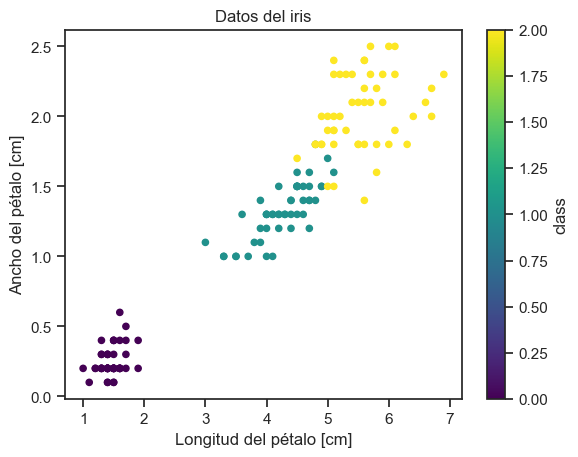

In [22]:
# Grafico
sns.set_context('notebook')
sns.set_style('ticks')

df.plot('petal_length', 'petal_width', kind='scatter', c='class', cmap='viridis')

plt.title(f'Datos del iris')
plt.xlabel('Longitud del pétalo [cm]')
plt.ylabel('Ancho del pétalo [cm]')

plt.show()

A medida que aumenta la longitud del pétalo, también aumenta el ancho del pétalo. 

Esta característica de la señal se cuantifica mediante la covarianza. 

Para 2 variables $x$ e $y$, la covarianza muestral correspondiente $s_{xy}$ se define como

$ s_{xy} = \frac{1}{n - 1} \sum\limits_{i = 1}^n (x_i - \bar{x}) (y_i - \bar{y}) $

$s_{xx}$: varianza muestral de $x$

$s_{yy}$: varianza muestral de $y$ 

Si $s_{xy}$:
- $> 0$:
    - $x$ e $y$ suben y bajan juntas.
- $< 0$:
    - El aumento de x está acompañado por la caída de y, y viceversa. 
    
La utilidad de la covarianza se ve obstaculizada por el hecho de que su magnitud depende de las unidades utilizadas. 

Ej: si las dimensiones de los pétalos se expresan en mm en lugar de cm, la covarianza correspondiente aumenta en 100.

Para eliminar ese problema, las variables $x$ e $y$ se pueden normalizar por división a través de la desviación estándar correspondiente, lo que lleva a la definición de correlación.


## 11.2.2 Coeficiente de correlación de Pearson

La correlación entre 2 variables responde a la pregunta: “¿Están las dos variables relacionadas linealmente? 

Si cambia una variable, ¿cambia también la otra?”. 

Si las 2 variables se distribuyen normalmente, la medida estándar para determinar el coeficiente de correlación, atribuida a Pearson, es

$ r = \sum_{i=1}^{n}(\frac{(x_i - \bar{x})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}} * \frac{(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}) $

$ s_{xy} = \frac{1}{n - 1} \sum\limits_{i = 1}^n (x_i - \bar{x}) (y_i - \bar{y}) $

$ s_{xx} = \frac{1}{n - 1} \sum\limits_{i = 1}^n (x_i - \bar{x}) (x_i - \bar{x}) $

$ s_{yy} = \frac{1}{n - 1} \sum\limits_{i = 1}^n (y_i - \bar{y}) (y_i - \bar{y}) $

$ s_{x} = \sqrt{s_{xx}} $

$ s_{y} = \sqrt{s_{yy}} $

$ \therefore ~ r = \frac{s_{xy}}{s_{x}s_{y}} $

Dado que los valores ahora están normalizados, el coeficiente no tiene dimensiones y puede tomar cualquier valor entre −1 y +1. 

In [7]:
# Con scipy
result1 = stats.pearsonr(df.petal_length, df.petal_width)
result1

PearsonRResult(statistic=0.962865431402796, pvalue=4.6750039073285846e-86)

In [8]:
# Con pingouin 
result2 = pg.corr(df.petal_length, df.petal_width)
result2.round(3)

,n,r,CI95%,p-val,BF10,power
pearson,150,0.963,"[0.95, 0.97]",0.0,1.113e+82,1.0


La fórmula para el coeficiente de correlación es simétrica entre $x$ e $y$, ¡lo cual no es el caso de la regresión lineal!

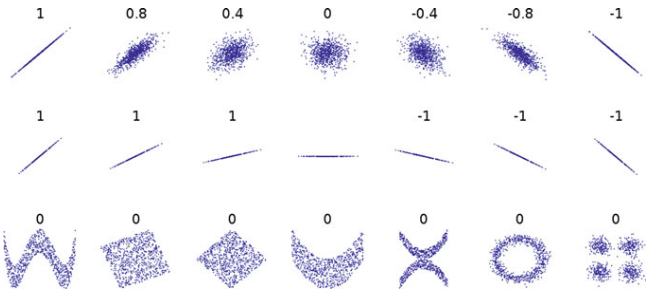

In [38]:
Image(filename = r'Imagenes/11.4.png')

## 11.2.3 Correlación de rango

Si la distribución de datos no es normal, es necesario un enfoque diferente. 

Se puede clasificar el conjunto de datos para cada variable y comparar los ordenamientos. 

Métodos para calcular la correlación de rango

- Spearman ($\rho$)
    - Es igual al coeficiente de correlación r de Pearson, pero calculado sobre los rangos de las observaciones y no sobre los números originales.

- Kendall ($\tau$)
    - Es un coeficiente de correlación de rango
    - Mide la asociación entre 2 cantidades medidas. 
    - Los intervalos de confianza para el $\rho$ de Spearman son menos confiables y menos interpretables que los intervalos de confianza para los parámetros $\tau$ de Kendall.

In [11]:
spearman_rho = pg.corr(df.petal_length, df.petal_width, method = 'spearman')
spearman_rho

,n,r,CI95%,p-val,power
spearman,150,0.937667,"[0.91, 0.95]",8.156597e-70,1.0


In [12]:
kendall_tau = pg.corr(df.petal_length, df.petal_width, method = 'kendall')
kendall_tau

,n,r,CI95%,p-val,power
kendall,150,0.806891,"[0.74, 0.86]",2.443446e-44,1.0


Comparamos la edad y el % de grasa (medido por absorciometría de doble fotón) para 18 adultos normales.

In [49]:
# Datos
data = np.genfromtxt(r'Datos/altman_11_1.txt', delimiter=',')
data

array([[23. ,  9.5],
       [23. , 27.9],
       [27. ,  7.8],
       [27. , 17.8],
       [39. , 31.4],
       [41. , 25.9],
       [45. , 27.4],
       [49. , 25.2],
       [50. , 31.1],
       [53. , 34.7],
       [53. , 42. ],
       [54. , 29.1],
       [56. , 32.5],
       [57. , 30.3],
       [58. , 33. ],
       [58. , 33.8],
       [60. , 41.1],
       [61. , 34.5]])

In [50]:
x = data[:,0]
y = data[:,1]

In [51]:
x

array([23., 23., 27., 27., 39., 41., 45., 49., 50., 53., 53., 54., 56.,
       57., 58., 58., 60., 61.])

In [52]:
y

array([ 9.5, 27.9,  7.8, 17.8, 31.4, 25.9, 27.4, 25.2, 31.1, 34.7, 42. ,
       29.1, 32.5, 30.3, 33. , 33.8, 41.1, 34.5])

In [53]:
pearson = stats.pearsonr(x, y)
pearson

PearsonRResult(statistic=0.7920862321784912, pvalue=8.93015175390132e-05)

In [54]:
spearman = stats.spearmanr(x, y)
spearman

SignificanceResult(statistic=0.7538795855376156, pvalue=0.0003020775580751178)

In [55]:
kendall = stats.kendalltau(x, y)
kendall

SignificanceResult(statistic=0.5762094850891228, pvalue=0.0009502496592265861)

In [24]:
# Afirmar que la rho de Spearman es solo la correlación de los datos ordenados por rango
np.testing.assert_almost_equal(spearman,stats.pearsonr(stats.rankdata(x), stats.rankdata(y))[0])

AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 1 / 2 (50%)
Max absolute difference: 0.75357751
Max relative difference: 0.9995993
 x: array([7.5387959e-01, 3.0207756e-04])
 y: array(0.7538796)

In [42]:
data = pd.read_csv(r'Datos\altman_11_6.txt', delimiter=',', header = None)

data.columns = ['glucose', 'Vcf']

data

,glucose,Vcf
0,15.3,1.76
1,10.8,1.34
2,8.1,1.27
3,19.5,1.47
4,7.2,1.27
5,5.3,1.49
6,9.3,1.31
7,11.1,1.09
8,7.5,1.18
9,12.2,1.22


In [43]:
data.dtypes

glucose    float64
Vcf         object
dtype: object

In [46]:
data['Vcf'] = data['Vcf'].astype(float)

In [47]:
results = smf.ols('Vcf ~ glucose', data=data).fit()

print(results.summary())    

                            OLS Regression Results                            
Dep. Variable:                    Vcf   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     4.414
Date:                Sat, 12 Aug 2023   Prob (F-statistic):             0.0479
Time:                        15:11:54   Log-Likelihood:                 3.5836
No. Observations:                  23   AIC:                            -3.167
Df Residuals:                      21   BIC:                           -0.8962
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0978      0.117      9.345      0.0

In [48]:
results.fvalue   

4.414018433146263

# 11.3 Coeficiente de Determinación

El coeficiente de correlación está estrechamente relacionado con la pendiente en la regresión lineal. 

Para la interpretación de su cuadrado $r^2$ (coeficiente de determinación), nos desviamos hacia los ajustes lineales.

## 11.3.1 Modelo de regresión lineal general

Lo usamos cuando queremos predecir el valor de una variable a partir de los valores de una o más variables. 

Ej: cuando buscamos la línea que mejor se ajusta a un conjunto de datos dado ($x_i$, $y_i$), buscamos los parámetros ($m$, $b$) que minimizan la suma de los cuadrados de los residuos $i$ en

$ y_i = m * x_i + b + \epsilon_i $

donde 
- $m$: pendiente o inclinación de la línea
- $b$: intercepto 
- $i$: residuos (diferencias entre los valores observados y los valores pronosticados). 


In [25]:
# Datos
x = np.arange(10)
np.random.seed(10)
y = 3*x + 2 + 20 * np.random.rand(len(x))

In [26]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
y

array([17.42641287,  5.41503899, 20.6729647 , 25.97607765, 23.97014025,
       21.49593291, 23.9612573 , 38.21061424, 29.38221673, 30.76679628])

In [28]:
# Determinar el ajuste de línea
k,d = np.polyfit(x,y,1)
yfit = k * x + d

In [29]:
k

2.2242622684657007

In [30]:
d

13.718564983143551

In [31]:
yfit

array([13.71856498, 15.94282725, 18.16708952, 20.39135179, 22.61561406,
       24.83987633, 27.06413859, 29.28840086, 31.51266313, 33.7369254 ])

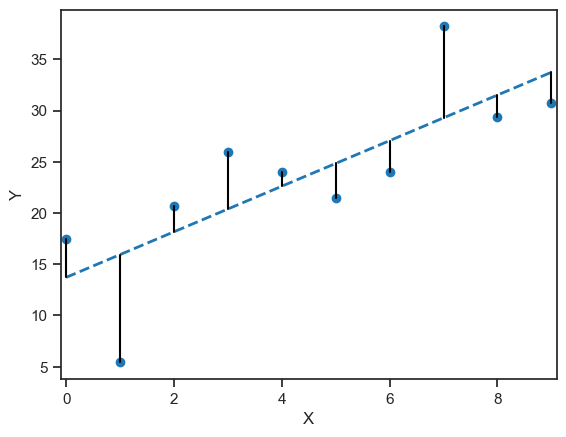

In [32]:
# Grafico
plt.scatter(x,y)
plt.plot(x, yfit, '--',lw=2)
for i in range(len(x)):
    plt.plot([x[i], x[i]], [yfit[i], y[i]], 'k')

plt.xlim((-0.1, 9.1))
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

Este es solo el ejemplo unidimensional de una técnica más general.

Se denomina regresión de mínimos cuadrados ordinarios (OLS) ya que la ecuación de regresión lineal se resuelve para minimizar la suma cuadrada de los residuos.

$ m = r * \frac{s_y}{s_x} $

donde 
- $s_x$ y $s_y$
    - Son las desviaciones estándar de la muestra en la dirección x e y 
    - Muestran la estrecha relación entre la pendiente m de un ajuste lineal y el coeficiente de correlación r

## 11.3.2 Interpretación 

Un conjunto de datos tiene valores $y_i$, cada uno de los cuales tiene un valor modelado asociado $\hat{y_i}$. 

$y_i$: valores observados

$\hat{y_i}$: valores modelados o pronosticados. 

Media de los datos observados ($\bar{y}$):

$ \bar{y} = \frac{1}{n} \sum\limits_{i = 1}^n  y_i$

$n$: número de observaciones

La “variabilidad” del conjunto de datos se mide a través de diferentes sumas de cuadrados:

-  Suma de Cuadrados del Modelo (o Suma de Cuadrados para la Regresión o Suma de Cuadrados Explicada)

$ SS_{mod} = \sum\limits_{i = 1}^n (\hat{y_i} - \bar{y})^2 $

- Suma de los cuadrados de los residuos (Suma de los Cuadrados de los Errores)
    
$ SS_{res} = \sum\limits_{i = 1}^n (y_i - \hat{y_i})^2 $

- Suma Total de Cuadrados
    - Es equivalente a la varianza muestral multiplicada por n − 1.

$ SS_{tot} = \sum\limits_{i = 1}^n (y_i - \bar{y})^2 $

Para modelos de regresión múltiple,

$ SS_{mod} + SS_{res} = SS_{tot} $


Coeficiente de determinación
- Es la relación entre la suma de cuadrados explicada por el modelo y la suma de cuadrados total. 
- Está relacionado con la varianza no explicada
- Compara la varianza no explicada (varianza de los errores del modelo) con la varianza total (de los datos)

$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = \frac{SS_{mod}}{SS_{tot}} $

In [2]:
# Estilo del gráfico
sns.set_context('notebook')
sns.set_style('ticks')

In [3]:
# Datos
yFit = lambda x: 1 + 0.5*x
x = np.r_[1., 2., 5., 6.]
y = yFit(x) + np.r_[-0.1, 0.1, -0.5, 0.5]

In [4]:
x

array([1., 2., 5., 6.])

In [7]:
yFit(x)

array([1.5, 2. , 3.5, 4. ])

In [5]:
y

array([1.4, 2.1, 3. , 4.5])

In [8]:
yMean = np.mean(y)
yMean

2.75

In [9]:
fit = np.polyfit(x,y,1)
fit

array([0.53529412, 0.87647059])

In [10]:
xSmooth = np.linspace(0.5, 6.5, 101)
xSmooth

array([0.5 , 0.56, 0.62, 0.68, 0.74, 0.8 , 0.86, 0.92, 0.98, 1.04, 1.1 ,
       1.16, 1.22, 1.28, 1.34, 1.4 , 1.46, 1.52, 1.58, 1.64, 1.7 , 1.76,
       1.82, 1.88, 1.94, 2.  , 2.06, 2.12, 2.18, 2.24, 2.3 , 2.36, 2.42,
       2.48, 2.54, 2.6 , 2.66, 2.72, 2.78, 2.84, 2.9 , 2.96, 3.02, 3.08,
       3.14, 3.2 , 3.26, 3.32, 3.38, 3.44, 3.5 , 3.56, 3.62, 3.68, 3.74,
       3.8 , 3.86, 3.92, 3.98, 4.04, 4.1 , 4.16, 4.22, 4.28, 4.34, 4.4 ,
       4.46, 4.52, 4.58, 4.64, 4.7 , 4.76, 4.82, 4.88, 4.94, 5.  , 5.06,
       5.12, 5.18, 5.24, 5.3 , 5.36, 5.42, 5.48, 5.54, 5.6 , 5.66, 5.72,
       5.78, 5.84, 5.9 , 5.96, 6.02, 6.08, 6.14, 6.2 , 6.26, 6.32, 6.38,
       6.44, 6.5 ])

In [11]:
ySmooth = np.polyval(fit, xSmooth)
ySmooth

array([1.14411765, 1.17623529, 1.20835294, 1.24047059, 1.27258824,
       1.30470588, 1.33682353, 1.36894118, 1.40105882, 1.43317647,
       1.46529412, 1.49741176, 1.52952941, 1.56164706, 1.59376471,
       1.62588235, 1.658     , 1.69011765, 1.72223529, 1.75435294,
       1.78647059, 1.81858824, 1.85070588, 1.88282353, 1.91494118,
       1.94705882, 1.97917647, 2.01129412, 2.04341176, 2.07552941,
       2.10764706, 2.13976471, 2.17188235, 2.204     , 2.23611765,
       2.26823529, 2.30035294, 2.33247059, 2.36458824, 2.39670588,
       2.42882353, 2.46094118, 2.49305882, 2.52517647, 2.55729412,
       2.58941176, 2.62152941, 2.65364706, 2.68576471, 2.71788235,
       2.75      , 2.78211765, 2.81423529, 2.84635294, 2.87847059,
       2.91058824, 2.94270588, 2.97482353, 3.00694118, 3.03905882,
       3.07117647, 3.10329412, 3.13541176, 3.16752941, 3.19964706,
       3.23176471, 3.26388235, 3.296     , 3.32811765, 3.36023529,
       3.39235294, 3.42447059, 3.45658824, 3.48870588, 3.52082

In [13]:
from matplotlib.patches import Rectangle

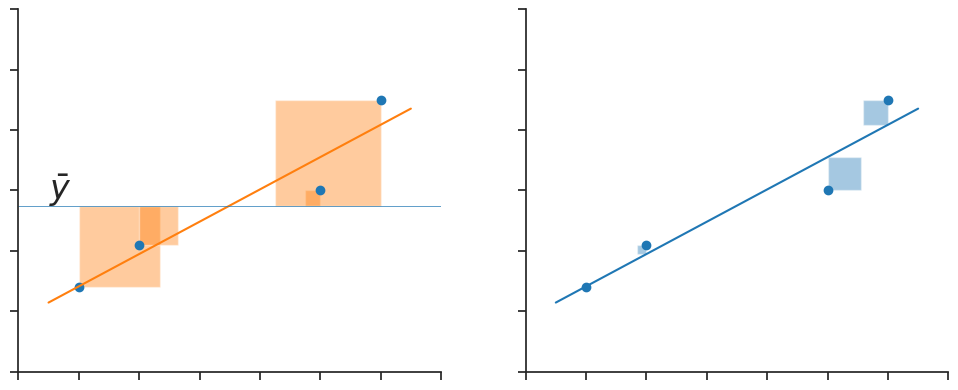

In [14]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

# Graficar los puntos de datos, re \bar{y}
axs[0].plot(x,y, 'o')
axs[0].plot(xSmooth, ySmooth, color='C1')

axs[0].set_xlim([0,7])
axs[0].set_ylim([0, 6])

axs[0].set_aspect('equal')
axs[0].hlines(yMean, 0, 7, lw=0.5)
axs[0].text(0.5, yMean+0.1, r'$\bar{y}$', fontsize=24)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

sns.despine(ax=axs[0])

for i in range(len(y)):
    width = yMean - y[i]
    rect = Rectangle( (x[i], y[i]), width=width, height=width,
                      facecolor='C1', alpha=0.4)
    axs[0].add_patch(rect)

# Graficar los puntos de datos, re \hat{y}
axs[1].plot(x,y, 'o')
axs[1].plot(xSmooth, ySmooth, color='C0')

axs[1].set_xlim([0,7])
axs[1].set_ylim([0, 6])
axs[1].set_aspect('equal')
sns.despine(ax=axs[1])
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

for i in range(len(y)):
    width = np.polyval(fit, x[i]) - y[i]
    rect = Rectangle( (x[i], y[i]), width=width, height=width,
                      facecolor='C0', alpha=0.4)
    axs[1].add_patch(rect)

plt.show()

Para la regresión lineal simple, $R^2$ es el cuadrado del coeficiente de correlación r. 

Valores de $R^2$ próximos a 1: corresponden a una correlación estrecha. 

Modelos generales escribimos $R^2$.

Para la regresión lineal simple se usa $r^2$.

La magnitud de los valores de $R^2$ para que se consideren "buenos" depende de la disciplina. 
- Deben ser más grandes en las ciencias físicas que en la biología o las ciencias sociales. 
- En finanzas o marketing depende de lo que se esté modelando. 

Precaución: La correlación de la muestra y R2 son engañosas si existe una relación no lineal entre las variables independientes y dependientes.

# 11.4 Matriz de diagrama de dispersión

Si tenemos de 3 a 6 variables que pueden estar relacionadas entre sí, podemos usar una matriz de diagramas de dispersión para visualizar las correlaciones entre las diferentes variables. 

Los elementos fuera de la diagonal de la matriz de diagramas de dispersión consisten en los diagramas de correlación, y los elementos diagonales son los histogramas o diagramas KDE de las variables correspondientes.

In [27]:
sns.set()

df = sns.load_dataset('iris')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


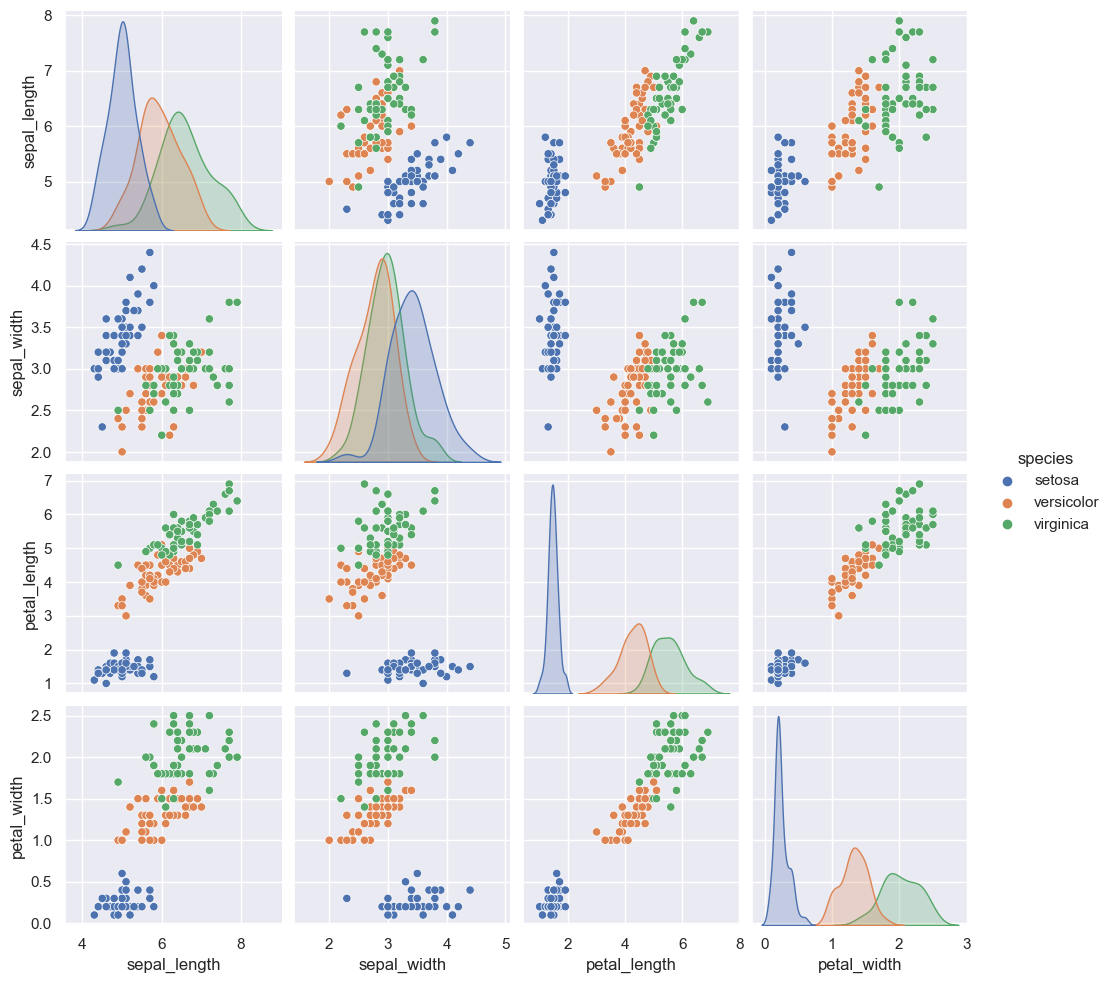

In [24]:
# Matriz de covarianza
sns.pairplot(df, hue="species", size=2.5)

plt.show()

In [28]:
df1 = df.drop(columns=['species'])
df1

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [29]:
cov_matrix = df1.cov()
cov_matrix

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,0.685694,-0.042434,1.274315,0.516271
sepal_width,-0.042434,0.189979,-0.329656,-0.121639
petal_length,1.274315,-0.329656,3.116278,1.295609
petal_width,0.516271,-0.121639,1.295609,0.581006


# 11.5 Matriz de Correlación

El coeficiente de correlación se reemplaza por la matriz de correlación, al pasar de 2 a 3 o más variables $x_i$.

$r_{ij}$: coeficiente de correlación entre las variables $x_i$ y $x_j$.

La regresión lineal debe ser reemplazada por una regresión multilineal (o regresión lineal múltiple) para predecir el valor de más de una de las otras variables. 

In [30]:
# Matriz de correlación
corr_matrix = df1.corr()
corr_matrix

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


Visualiza la correlación entre un gran número de variables. 

Usando seaborn, el siguiente ejemplo muestra cómo implementar una matriz de correlaciones. En el ejemplo, el parámetro para np.random. RandomState es la semilla para la generación de números aleatorios. Los datos son normalmente datos ficticios distribuidos, simulando 100 registros de cada una de las 26 variables diferentes. La siguiente lista calcula y visualiza la correlación cruzada entre cada posible combinación de variables (Fig.11.8):



In [31]:
from string import ascii_letters

In [33]:
sns.set_theme(style = 'white')

In [34]:
# Generar un gran conjunto de datos aleatorios 
rs = np.random.RandomState(1234)
df = pd.DataFrame(data = rs.normal(size = (100, 26)), columns = list(ascii_letters[26:]))
df.head()

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,0.471435,-1.190976,1.432707,-0.312652,-0.720589,0.887163,0.859588,-0.636524,0.015696,-2.242685,...,0.405453,0.289092,1.321158,-1.546906,-0.202646,-0.655969,0.193421,0.553439,1.318152,-0.469305
1,0.675554,-1.817027,-0.183109,1.058969,-0.397840,0.337438,1.047579,1.045938,0.863717,-0.122092,...,0.036142,-2.074978,0.247792,-0.897157,-0.136795,0.018289,0.755414,0.215269,0.841009,-1.445810
2,-1.401973,-0.100918,-0.548242,-0.144620,0.354020,-0.035513,0.565738,1.545659,-0.974236,-0.070345,...,0.211883,0.704721,-0.785435,0.462060,0.704228,0.523508,-0.926254,2.007843,0.226963,-1.152659
3,0.631979,0.039513,0.464392,-3.563517,1.321106,0.152631,0.164530,-0.430096,0.767369,0.984920,...,0.816594,-0.081947,-0.344766,0.528288,-1.068989,-0.511881,0.291205,0.566534,0.503592,0.285296
4,0.484288,1.363482,-0.781105,-0.468018,1.224574,-1.281108,0.875476,-1.710715,-0.450765,0.749164,...,-0.248432,-0.617707,-0.682884,0.436258,-1.703013,0.393711,-0.479324,-0.299016,0.694103,0.678630


In [35]:
# Matriz de correlación
corr = df.corr()
corr

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
A,1.000000,-0.046109,0.058020,-0.017957,-0.067054,-0.075861,0.222280,0.154479,0.038472,-0.007104,...,0.059259,0.164122,0.217464,0.025776,-0.231187,-0.004831,-0.004986,0.009200,0.007090,0.020336
B,-0.046109,1.000000,-0.072547,-0.076305,0.217535,0.097092,0.095029,-0.136428,-0.304798,0.040551,...,0.055103,-0.082483,-0.113152,0.021974,-0.075182,-0.094793,-0.092476,-0.127154,0.027288,0.002047
C,0.058020,-0.072547,1.000000,0.014646,-0.033077,-0.037511,-0.008389,0.086908,0.073571,0.069252,...,-0.063203,-0.022666,0.036231,0.156136,-0.162812,-0.233852,-0.003411,0.031588,-0.062734,0.008436
D,-0.017957,-0.076305,0.014646,1.000000,-0.128424,-0.080462,-0.055290,0.152279,-0.060838,-0.099906,...,-0.002822,-0.094902,-0.005603,0.048971,0.109265,-0.035217,-0.176692,-0.005631,-0.168488,0.045388
E,-0.067054,0.217535,-0.033077,-0.128424,1.000000,0.007408,-0.038903,-0.187235,-0.173664,0.147077,...,-0.009971,-0.114738,-0.081596,0.191092,0.064856,-0.112323,0.016801,0.069753,0.075312,0.119426
F,-0.075861,0.097092,-0.037511,-0.080462,0.007408,1.000000,0.171156,-0.116037,-0.014374,-0.004714,...,0.006616,-0.031547,-0.012762,-0.114550,0.088384,-0.211050,-0.033860,0.025518,0.079271,-0.153565
G,0.222280,0.095029,-0.008389,-0.055290,-0.038903,0.171156,1.000000,-0.053425,0.001738,-0.262807,...,-0.169035,-0.024638,0.134881,-0.055601,-0.126278,-0.123985,-0.042561,0.017246,-0.067594,-0.054151
H,0.154479,-0.136428,0.086908,0.152279,-0.187235,-0.116037,-0.053425,1.000000,-0.037516,0.070765,...,-0.012788,0.261152,-0.060732,0.149921,0.055370,0.194343,-0.164443,0.057965,0.152981,-0.051998
I,0.038472,-0.304798,0.073571,-0.060838,-0.173664,-0.014374,0.001738,-0.037516,1.000000,-0.028126,...,0.022384,0.044004,-0.151247,-0.034357,-0.127359,-0.083563,0.069434,0.107250,0.083893,0.050651
J,-0.007104,0.040551,0.069252,-0.099906,0.147077,-0.004714,-0.262807,0.070765,-0.028126,1.000000,...,-0.016207,0.133991,0.087587,0.077060,0.108012,0.177796,-0.041193,-0.053394,-0.104101,-0.089601


In [36]:
# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype = bool))
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

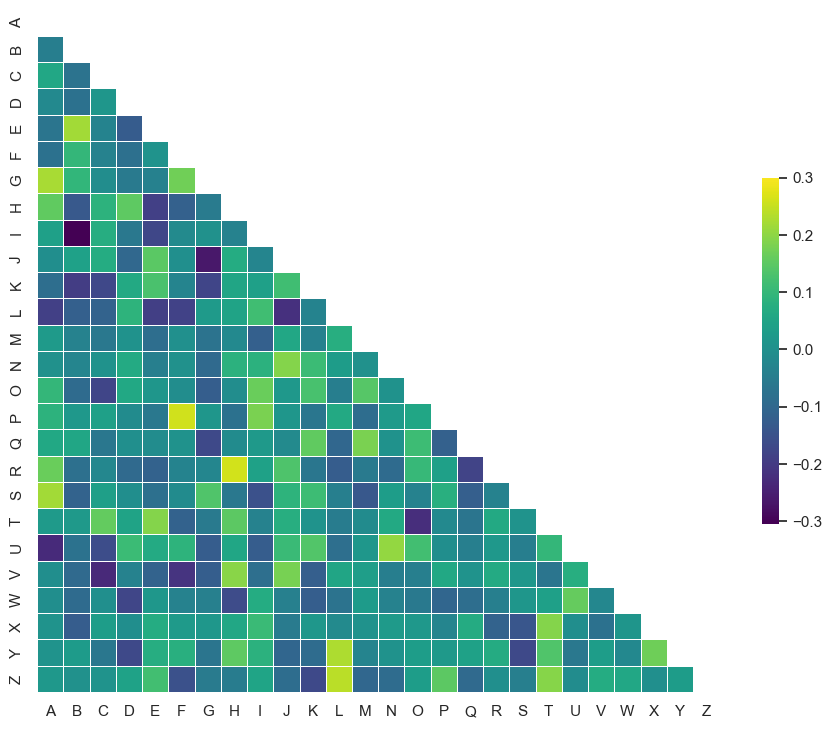

In [37]:
# Grafico
fig, ax = plt.subplots(figsize = (11,9))

# Generar un mapa de colores personalizado
cmap = sns.color_palette('viridis', as_cmap = True)

# Dibuja el mapa de calor con la máscara y la relación de aspecto correcta
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0,
           square = True, linewidths = 0.5, cbar_kws = {'shrink': 0.5})
plt.show()

# 11.6 Autocorrelación

Para encontrar patrones repetidos y desconocidos dentro de una señal, la señal se puede comparar con versiones cambiadas de sí misma, lo que lleva a la "autocorrelación". 

Los coeficientes de autocorrelación se definen como los "coeficientes de autocovarianza", normalizados por la varianza.

El coeficiente de autocovarianza en el desfase $k$ viene dado por la correlación cruzada entre una señal y una copia de sí misma que se desplaza en $k$ puntos, donde se ha restado el valor medio. 

En la práctica, los coeficientes de autocorrelación se calculan calculando la serie de coeficientes de autocovarianza de la muestra en el desfase $k$ como

$ c_k = \frac{1}{N} \sum\limits_{i = 1}^{N - K} (x_t - \bar{x}) (x_{t+k} - \bar{x}) $

Coeficientes de autocorrelación

$ r_k = \frac{c_k}{c_0} $

La correlación cruzada se usa comúnmente para encontrar la ocurrencia de una característica más corta en una señal más larga. 

La función de autocorrelación se usa comúnmente para detectar características repetitivas en señales más largas. 

# 11.7 Análisis de series de tiempo

Análisis de series temporales. 

Análisis de series temporales (TSA): ciencia que trata de extraer información de los datos registrados en función del tiempo.

Objetivos: 
1. La descripción concisa de las señales registradas 
2. La explicación de los patrones observados 
3. La predicción de eventos futuros 
4. El control de los sistemas bajo observación 

Se concentra en datos registrados con intervalos de tiempo fijos. 

Clases de métodos para el análisis de datos:
- Métodos en el dominio de la frecuencia
    - Incluye análisis
        - Espectral
        - Wavelet

- Métodos en el dominio del tiempo
    - Incluye análisis de
        - Autocorrelación
        - Correlación cruzada
        
Ejemplo de un análisis de series de tiempo

Dado que el calentamiento global es posiblemente el desafío más apremiante que enfrenta la humanidad actualmente, se utilizarán datos sobre las tendencias en el dióxido de carbono atmosférico de la Administración Nacional Oceánica y Atmosférica (NOAA). 

Para ser representativos del estado de la atmósfera global, estos datos se registraron en la cima de una montaña remota en una isla del Pacífico, en Mauna Loa en Hawai. 

Constituyen el registro disponible más largo de mediciones directas de $CO_2$ en la atmósfera y muestran cuán masivamente ya hemos cambiado el aire en nuestro planeta.

In [11]:
url = 'https://www.esrl.noaa.gov/gmd/webdata/ccgg/trends/co2/co2_mm_mlo.txt'

df = pd.read_csv(url, skiprows=57, delim_whitespace=True)
df.head()

,#,date,average,alized,of,days,mon,mean
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [12]:
df.columns = ['year', 'month', 'time', 'co2', 'deseasoned', 'nr_days', 'std_days', 'uncertainty']
df

,year,month,time,co2,deseasoned,nr_days,std_days,uncertainty
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
779,2023,2,2023.1250,420.30,419.37,23,0.71,0.28
780,2023,3,2023.2083,420.98,419.53,30,0.74,0.26
781,2023,4,2023.2917,423.36,420.67,28,0.60,0.22
782,2023,5,2023.3750,424.00,420.54,31,0.69,0.24


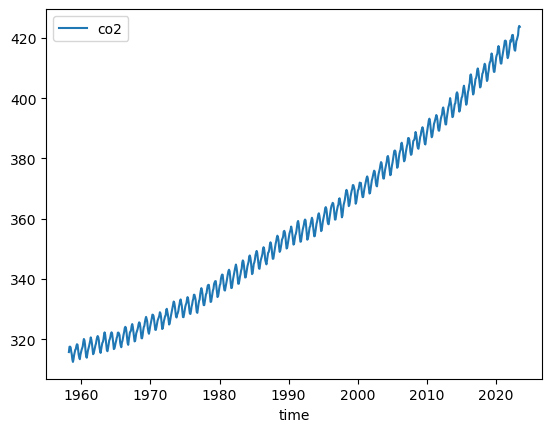

In [13]:
df.plot('time', 'co2');

In [2]:
signal = np.zeros(50)
signal[7:10] = 1
signal[14:17] = 1

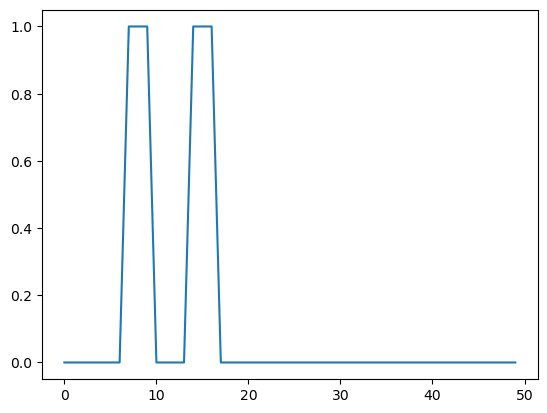

In [3]:
plt.plot(signal)

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

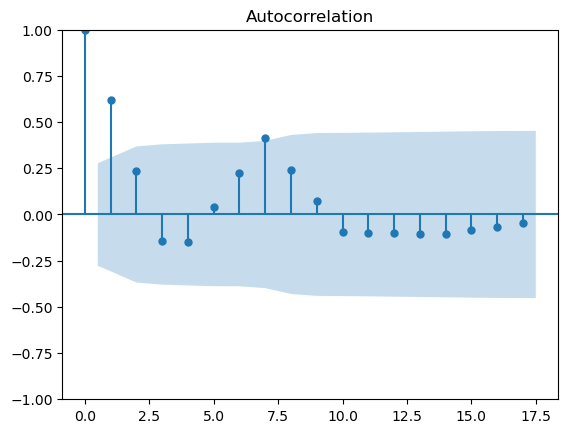

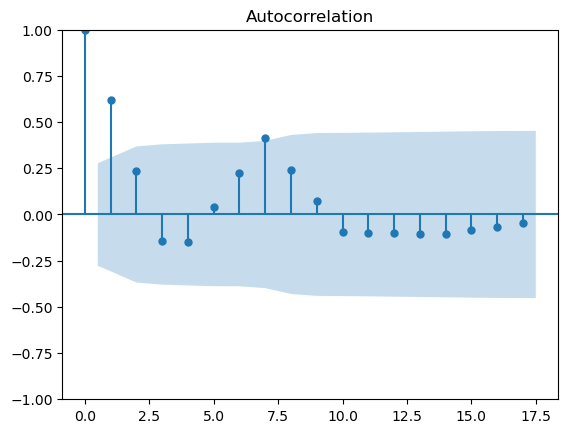

In [6]:
plot_acf(signal)

## 11.7.1 Descomposición de datos

La mayoría de los modelos que se utilizan para explicar las características de los datos observados asumen que el proceso es estacionario.

Primer paso en el manejo de datos: descomponer los datos en los componentes Tendencia, Estacionalidad y Residuales. 

La descomposición puede ser aditiva

$ data = Tendencia + Estacionalidad + Residuales $ 

o multiplicativa

$ data = Tendencia ~*~ Estacionalidad ~*~ Residuales $ 


Realice una descomposición estacional de los datos de entrada y muestre la autocorrelación (ACF) y la autocorrelación parcial (PACF) de los residuos.

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
# Descomposición estacional
result_add = seasonal_decompose(df['co2'], model='additive', period=12, extrapolate_trend='freq')
result_add

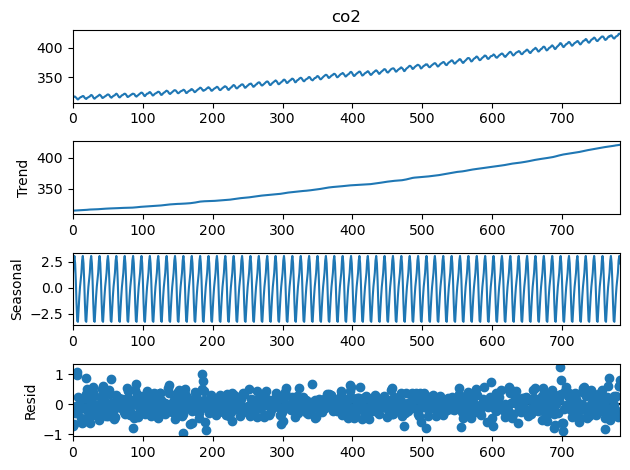

In [17]:
result_add.plot()

plt.show()

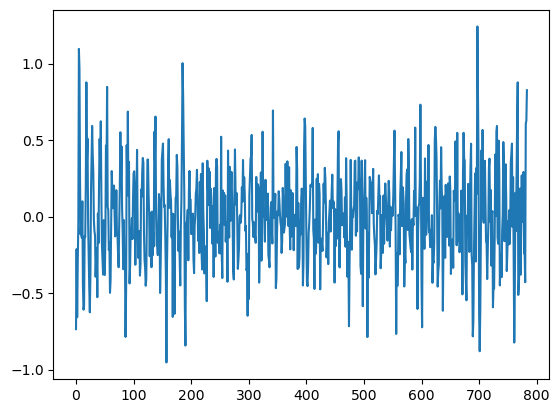

In [20]:
plt.plot(result_add.resid, '-')

#plt.xlim(0, 100)

plt.show()

## 11.7.2 Análisis de Residuos

### a) Autocorrelación

Se usa para encontrar patrones sistemáticos desconocidos en los Residuos. 

Se requiere una experiencia considerable para interpretar los coeficientes de autocorrelación de la muestra. 

Es necesario estudiar la teoría de probabilidad de series estacionarias y conocer las clases de modelos que pueden ser apropiados. 

Función de autocorrelación (ACF) 

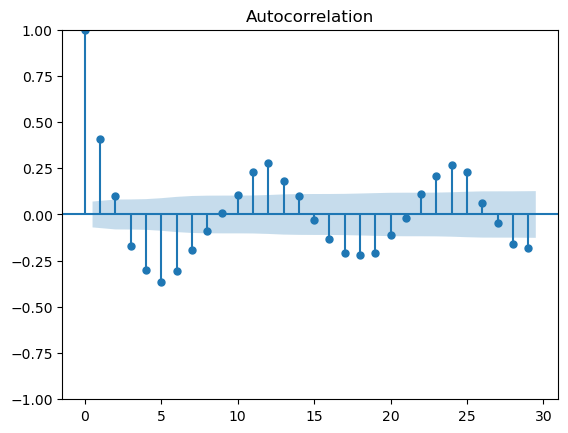

In [21]:
# Función de autocorrelación
plot_acf(result_add.resid)

plt.show()

Las oscilaciones restantes con una duración de 12 pasos de tiempo indican que aún quedan algunos efectos estacionales en los Residuales. 

La información del ACF puede analizarse más en los modelos TSA. 

Una vez que se han eliminado la tendencia principal y los componentes estacionales, se utilizan modelos para ver cómo se pueden explicar mejor las características restantes de los datos. 

### b) Autocorrelación parcial 

Los patrones cíclicos (restantes) en la señal inducen picos repetidos en el ACF, ya que los cambios de señal cíclica en uno, dos o más ciclos conducen a patrones de señal coincidentes. 

Para eliminar esa "redundancia", la función de autocorrelación parcial (PACF) para un retraso k se define como la correlación restante que no se explica por retrasos más pequeños. 

La función de correlación y la función de correlación parcial se utilizan en la evaluación de modelos autorregresivos.

PACF para series de tiempo estacionarias de media cero:

Sea $\hat{x_{t+h}}$, para $h \geq 2$, 

$ x_{t+h} $ = $ x_{t+h-1} $, $ x_{t+h-2} $, ..., $ x_{t+1} $

$ \hat{x_{t+h}} = \beta_1  x_{t+h-1} + \beta_2 x_{t+h-2} + ... + \beta_{h-1} x_{t+1}$

$ \hat{x_{t}} = \beta_1  x_{t+1} + \beta_2 x_{t+2} + ... + \beta_{h-1} x_{t + h - 1}$

Debido a la estacionariedad, los coeficientes, $\beta_1,...,\beta_{h-1}$ son los mismos.

Función de autocorrelación parcial (PACF) de un proceso estacionario $x_t$

$ pacf(1) = corr(x_{t+1},x_{t}) $

$ pacf(h) = corr(x_{t+h} - \hat{x_{t+h}},x_{t} - \hat{x_{t}}) $, $h \geq 2$

corr es el coeficiente de correlación. 

$ pacf(h)$ es la correlación entre $x_{t+h}$ y $x_{t}$, con la dependencia lineal de $ x_{t+1} $,..., $x_{t+h-1}$ en cada uno eliminado.

In [23]:
from statsmodels.graphics.tsaplots import plot_pacf

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


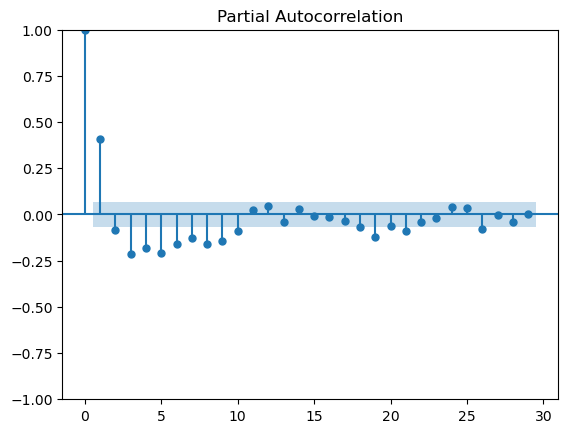

In [24]:
# Función de autocorrelación parcial
plot_pacf(result_add.resid)

plt.show()

## 11.7.3 Modelos ARMA

Modelos de promedio móvil integrados autorregresivos (ARIMA) se utilizan para explicar las series de tiempo. 

### a) Supuestos de los modelos ARMA

Modelos de promedio móvil autorregresivo (ARMA)

Asumen que

- Los datos provienen de un proceso estacionario. 
    - Una serie de tiempo es “estacionaria” si 
        - No hay un cambio sistemático en la media y/o en la varianza 
        - Se han eliminado las variaciones estrictamente periódicas.

- El proceso está impulsado por eventos externos aleatorios que tienen media cero y se distribuyen normalmente. 

$Z_t$: 
- Entradas externas aleatorias que se supone que impulsan los procesos observados
- Tienen una varianza de $\sigma_Z^2$


### b) Procesos de Media Móvil (MA)

Un proceso $X_t$ es un “proceso de media móvil de orden $q$" MA(q), si

$ X_t = \beta_0 Z_t + \beta_1 Z_{t-1} + ... + \beta_q Z_{t-q} $

Los coeficientes MA $\beta_i$ son constantes. 

Los $Z_i$ suelen estar escalados de forma que $\beta_0 = 1$.

Un evento en el tiempo $t_i$ modifica la señal en un tiempo posterior $t_{i+k}$ en $\beta_k$ , para $k = 1, 2,..., q$. 

No se sentirán más efectos de este evento después de $t_{i+q}$.


### c) Procesos autorregresivos (AR)

Un proceso $X_t$ es un “proceso autorregresivo de orden $p$” (AR(p)), si

$ X_t = \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + Z_t $

Un evento en el tiempo $t_i$ es recordado en un tiempo posterior $t_{i+k}$ con una fuerza determinada por los coeficientes AR $\alpha_k$ , para $k = 1, 2,..., p.$ 

No se sentirán más efectos de memoria de este evento después de $t_{i+p}$. 

Se conoce como un proceso "autoregresivo" porque es como un modelo de regresión múltiple, pero con $X_t$ retrocediendo sobre valores pasados de $X_t$ en lugar de variables predictoras separadas.

### d) Modelos ARMA 

Procesos ARMA: Combinaciones de procesos autorregresivos (AR) y los procesos de promedio móvil (MA).

## 11.7.4 Modelos ARMA (o ARIMA) integrados

La mayoría de las series temporales son no estacionarias. 

Las fuentes de variación no estacionarias pueden eliminarse mediante diferenciación simple o múltiple. 

Se denomina modelo integrado (ARIMA) porque el modelo estacionario que se ajusta a los datos diferenciados debe sumarse o "integrarse" para proporcionar un modelo para los datos no estacionarios originales. 

Indicamos la diferenciación como B (operador de cambio de tiempo)

$ B X_t = X_{t-1} $

$ B^2 X_t = X_{t-2} $

$ ... $

Diferenciación d-veces de $X_t$ 

$ W_t = \Delta^d X_t = (1 - B)^d X_t$, $d = 0,1,2$

Proceso general de ARIMA

$ W_t = \alpha_1 W_{t-1} + ... + \alpha_p W_{t-p} + Z_t + \beta_1 Z_{t-1} + ... + \beta_q Z_{t-q} $

$ \sum\limits_{i=0}^{p} \alpha_i W_{t-i} = \sum\limits_{j=0}^{q} \beta_j W_{t-j} $

donde $\alpha_0 = \beta_0 = 1$ 

La serie de tiempo diferenciada $ W_t $ forma un proceso $ARMA(p, q)$

Se conoce como proceso ARIMA del orden (p, d, q) porque $ W_t $ se obtiene de $ X_t $ a través de la diferenciación de d-tiempos.

## 11.7.5 Ejemplos de modelos ARIMA simples

### a) Identificación de modelos AR y MA

Modelos de media móvil ARMA(1, 0)

$ X_t = 1 * Z_t \pm 0.9 * Z_{t-1}$

In [52]:
# Parámetros
ars = [(None, [1,  0.9]),
       (None, [1, -0.9])]
mas = [([1,  0.9], None),
       ([1, -0.9], None) ]


ARMA = (None, [1, 0.9])
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1419.946
Date:                Mon, 31 Jul 2023   AIC                           2845.892
Time:                        17:23:52   BIC                           2860.616
Sample:                             0   HQIC                          2851.488
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0754      0.061     -1.244      0.213      -0.194       0.043
ma.L1          0.9106      0.013     67.979      0.000       0.884       0.937
sigma2         1.0002      0

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ARMA = (None, [1, -0.9])
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1420.500
Date:                Mon, 31 Jul 2023   AIC                           2846.999
Time:                        17:23:52   BIC                           2861.723
Sample:                             0   HQIC                          2852.595
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.003     -1.162      0.245      -0.010       0.003
ma.L1         -0.8967      0.014    -65.162      0.000      -0.924      -0.870
sigma2         1.0015      

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


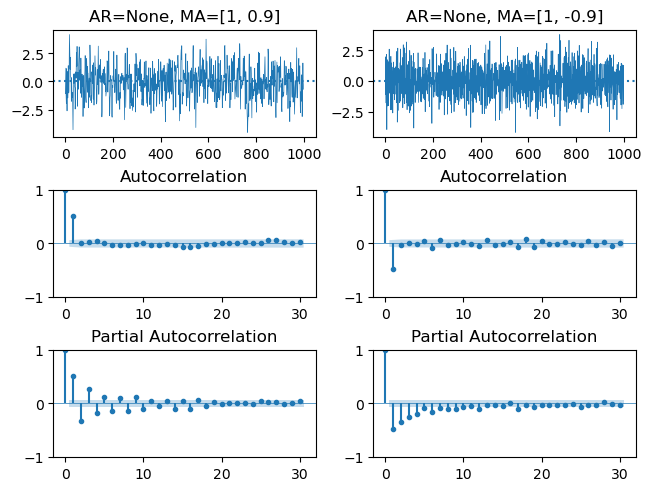

In [53]:
fig, axs = plt.subplots(3,2, constrained_layout=True)

for (i, arma) in enumerate(ars):
    ar = arma[0]
    ma = arma[1]
    n_samples = 1000
    # Datos
    np.random.seed(123)      
    arma_process = tsa.arima_process.ArmaProcess(ar, ma)
    y = arma_process.generate_sample(n_samples)
    
    # Ajusto el modelo
    if ar is None:
        model = ARIMA(y, order=(0,0,1)).fit()
    else:
        model = ARIMA(y, order=(1,0,0)).fit()

    print(f'ARMA = {arma}')
    print(model.summary())

    # Grafico los datos,  ACF y PACF
    axs[0, i].plot(y, lw=0.5)
    axs[0, i].axhline(0, ls='dotted')
    axs[0, i].set_title(f'AR={ar}, MA={ma}')
    plot_acf(y, ax=axs[1, i], lw=0.5, markersize=3)
    plot_pacf(y, ax=axs[2, i], lw=0.5, markersize=3)
    # plt.tight_layout()

plt.show()

Estos modelos corresponden a un proceso de media móvil de orden 1 (proceso MA(1)), y los coeficientes MA correspondientes son ma=[1, $\pm$ 0.9]. 

El modelo MA de la izquierda, ma = [1, 0,9], es efectivamente un filtro de paso bajo que promedia 2 números aleatorios

El modelo MA de la derecha, ma = [1, −0,9], diferencia efectivamente 2 números aleatorios adyacentes. 

Para un proceso MA(1), solo los dos primeros valores de ACF son significativos.

ARMA(0,1)

$ X_t = \pm 0.9 * X_{t-1} + Z_t $

In [54]:
# Parámetros
ars = [([1,  0.9], None),
       ([1, -0.9], None) ]
mas = [(None, [1,  0.9]),
       (None, [1, -0.9])]

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


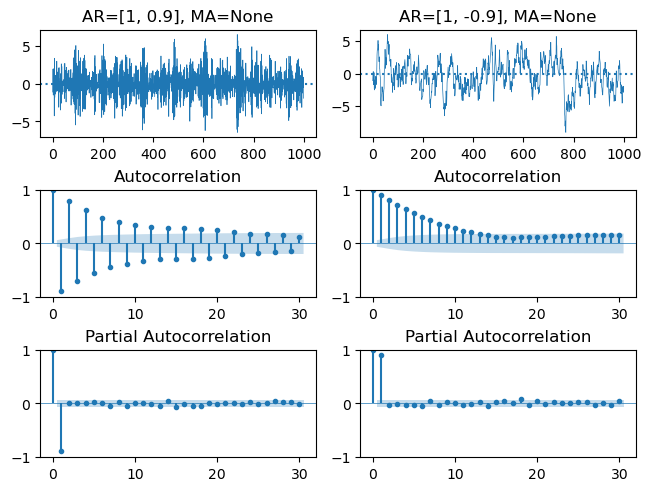

In [56]:
fig, axs = plt.subplots(3,2, constrained_layout=True)

for (i, arma) in enumerate(ars):
    ar = arma[0]
    ma = arma[1]
    n_samples = 1000
    # Datos
    np.random.seed(123)      
    arma_process = tsa.arima_process.ArmaProcess(ar, ma)
    y = arma_process.generate_sample(n_samples)
    
    # Grafico los datos,  ACF y PACF
    axs[0, i].plot(y, lw=0.5)
    axs[0, i].axhline(0, ls='dotted')
    axs[0, i].set_title(f'AR={ar}, MA={ma}')
    plot_acf(y, ax=axs[1, i], lw=0.5, markersize=3)
    plot_pacf(y, ax=axs[2, i], lw=0.5, markersize=3)
    # plt.tight_layout()

plt.show()

Los coeficientes correspondientes a estos procesos AR(1) son ar = [1, $\mp$ 0.9]. 

La izquierda salta entre valores positivos y negativos.

La derecha corresponde a un "recorrido aleatorio relajado".

Los roles del ACF y el Los PACF ahora están invertidos: para los procesos AR(1)
- Solo los 2 primeros valores del PACF son significativos
- El ACF muestra un comportamiento de descomposición lenta, lo que no ayuda a identificar claramente el proceso subyacente. 

Cómo determinar el orden del proceso subyacente para procesos AR y MA puros.

||AR(p)|MA(q)|ARMA(p,q)|
|---|---|---|---|
|ACF|Colas fuera|Se corta después del retraso q|Colas fuera|
|PACF|Se corta después del retraso p|Colas fuera|Colas fuera|

### b) Montaje de modelos ARMA

Una vez determinado el orden o un modelo ARIMA (o en la práctica: estimado), el los coeficientes del modelo correspondiente se pueden encontrar fácilmente.

ARMA(0,1)

$ X_t = \pm 0.9 * X_{t-1} + Z_t $

In [ ]:
# Parámetros
ars = [([1,  0.9], None),
       ([1, -0.9], None) ]
mas = [(None, [1,  0.9]),
       (None, [1, -0.9])]

In [58]:
# Ajusto el modelo
for (i, arma) in enumerate(ars):
    ar = arma[0]
    ma = arma[1]
    n_samples = 1000
    
    if ar is None:
        model = ARIMA(y, order=(0,0,1)).fit()
    else:
        model = ARIMA(y, order=(1,0,0)).fit()

    print(f'ARMA = {arma}\n')
    print(model.summary())

ARMA = ([1, 0.9], None)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1420.051
Date:                Mon, 31 Jul 2023   AIC                           2846.103
Time:                        17:54:30   BIC                           2860.826
Sample:                             0   HQIC                          2851.699
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3986      0.320     -1.247      0.212      -1.025       0.228
ar.L1          0.9011      0.013     67.552      0.000       0.875       0.927
sigma2         1.0005      

In [ ]:
######################## Codigos accesorios ##########################

In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [27]:
model1 = ARIMA(result_add.resid, order=(1,0,1)).fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  784
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -109.189
Date:                Mon, 31 Jul 2023   AIC                            226.377
Time:                        14:06:39   BIC                            245.035
Sample:                             0   HQIC                           233.551
                                - 784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.016      0.021      0.983      -0.032       0.033
ar.L1          0.3313      0.077      4.301      0.000       0.180       0.482
ma.L1          0.1025      0.084      1.217      0.2

In [28]:
model2 = ARIMA(result_add.resid, order=(0,0,2)).fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  784
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -104.029
Date:                Mon, 31 Jul 2023   AIC                            216.058
Time:                        14:06:58   BIC                            234.715
Sample:                             0   HQIC                           223.232
                                - 784                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.016      0.018      0.986      -0.031       0.032
ma.L1          0.4359      0.036     12.258      0.000       0.366       0.506
ma.L2          0.2027      0.032      6.309      0.0

In [29]:
x = [0, 0]

for i in range(200):
    x.append(x[-1] - 0.5 * x[-2] + float(np.random.randn(1)))

In [30]:
x

[0,
 0,
 -0.4271858754172216,
 0.29541033298311986,
 0.3476960933714559,
 1.283097650530849,
 0.38860612347556933,
 0.06190425457134957,
 -0.9064236583950402,
 -1.311027258867307,
 -0.04043658053988375,
 -1.2511126487688964,
 -1.134453787761195,
 -1.2054396533583511,
 -1.3919272480207203,
 -1.9358154449743583,
 -2.3430158945528836,
 -2.146640659775322,
 -1.9708882699315435,
 -0.42110009623943356,
 0.12117764107430701,
 1.1549695949804304,
 1.2172819119420761,
 1.5086084913810007,
 1.1221190527086962,
 -1.5892063403845262,
 -1.2071728583316264,
 -0.6948812928214478,
 0.43922831593351497,
 2.197885363854682,
 1.79813493623284,
 1.715072005334956,
 1.0273991273610084,
 -1.0117517995727399,
 -2.444368424488282,
 -1.1470564485909538,
 2.2022446799191746,
 2.9929860242040167,
 2.316761735457531,
 1.0144592411756452,
 -0.5488628402693707,
 -0.393083773846195,
 1.2096354011810415,
 0.39449192935532396,
 -0.03828667633306215,
 1.1949457928599447,
 1.5167578250936182,
 0.1438350209529493,
 -1.64

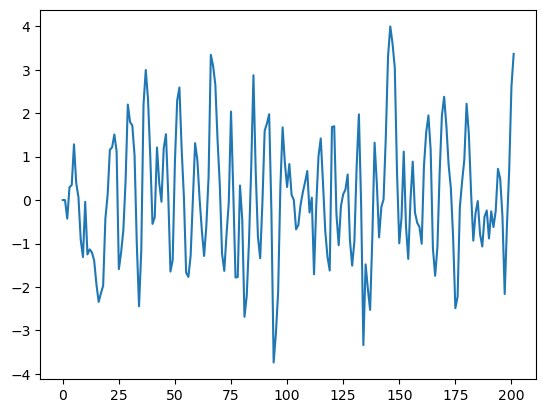

In [31]:
plt.plot(x)

In [32]:
from statsmodels import tsa

In [33]:
np.set_printoptions(precision=2)
np.random.seed(12345)

arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])

ar = np.r_[1, -arparams] # añadir retraso cero y negativo
ma = np.r_[1, maparams] # añadir retraso cero

In [34]:
arma_process = tsa.arima_process.ArmaProcess(ar, ma)
arma_process

ArmaProcess([1.0, -0.75, 0.25], [1.0, 0.65, 0.35], nobs=100) at 0x11b4c624d00

In [35]:
y = arma_process.generate_sample(250)
y

array([-0.2 ,  0.19, -0.08, -0.84,  0.82,  3.3 ,  3.96,  2.97,  2.22,
        2.77,  3.61,  1.81,  0.24, -0.32,  1.3 ,  2.9 ,  0.9 , -1.41,
       -0.56,  0.45,  0.24,  0.04,  3.34,  3.75,  1.88, -0.14, -0.39,
        0.5 ,  0.92,  2.09,  1.5 , -0.22, -3.7 , -6.41, -6.78, -4.14,
       -2.61, -1.43, -1.85, -1.35, -3.06, -3.58, -4.41, -4.46, -4.72,
       -3.33, -1.21, -0.48, -0.09,  1.36,  2.1 ,  2.  ,  1.15,  1.44,
        2.77,  2.01, -0.87, -2.46, -1.4 , -0.59,  0.6 ,  0.92,  0.88,
        1.13,  1.93,  1.  , -0.08, -2.96, -4.36, -4.98, -5.  , -2.72,
        0.16,  2.34,  3.42,  2.37,  0.32, -1.85, -3.01, -2.37, -1.08,
       -1.26, -0.6 ,  0.43,  2.05,  4.06,  3.08,  2.13,  0.9 ,  1.27,
        1.46,  3.39,  3.54,  4.49,  3.78,  3.23,  2.12,  0.39, -0.1 ,
        0.1 , -1.16, -2.42, -2.47, -2.4 , -2.28, -1.78,  0.13,  2.23,
        2.07,  2.54,  1.68,  1.29,  1.59,  0.07, -2.07, -3.18, -2.27,
       -1.1 ,  0.36, -0.73, -3.73, -5.82, -4.63, -1.49,  0.34,  0.56,
        0.25, -0.53,

In [36]:
model3 = tsa.arima.model.ARIMA(y, order=(2, 0, 2), trend='n').fit()
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -353.445
Date:                Mon, 31 Jul 2023   AIC                            716.891
Time:                        14:12:08   BIC                            734.498
Sample:                             0   HQIC                           723.977
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7905      0.142      5.566      0.000       0.512       1.069
ar.L2         -0.2314      0.124     -1.859      0.063      -0.475       0.013
ma.L1          0.7007      0.131      5.344      0.0

In [37]:
model3.params

array([ 0.79, -0.23,  0.7 ,  0.41,  0.98])

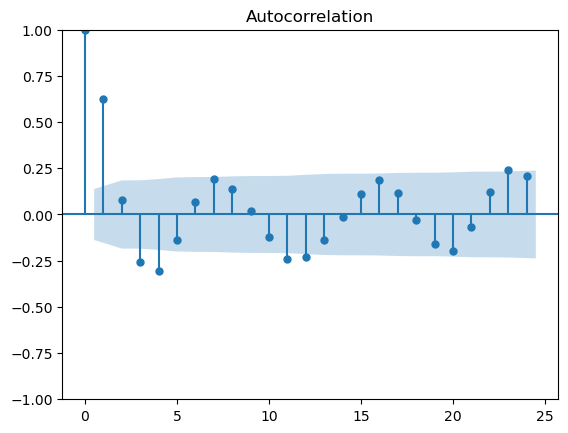

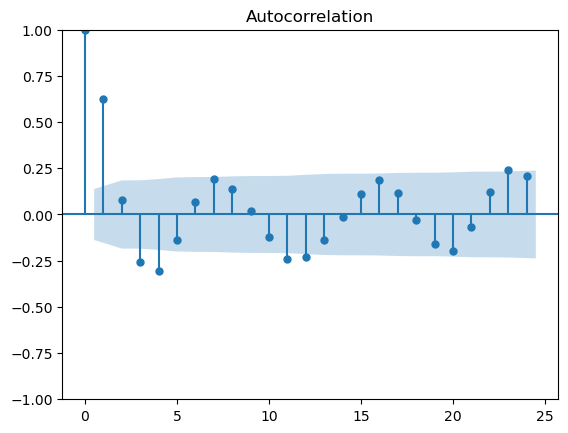

In [38]:
plot_acf(np.array(x))

In [39]:
model4 = ARIMA(np.array(x), order=(2,0,0)).fit()
print(model4.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  202
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -274.569
Date:                Mon, 31 Jul 2023   AIC                            557.138
Time:                        14:14:00   BIC                            570.371
Sample:                             0   HQIC                           562.492
                                - 202                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0667      0.120      0.556      0.578      -0.169       0.302
ar.L1          0.9781      0.056     17.484      0.000       0.868       1.088
ar.L2         -0.5380      0.056     -9.688      0.0

In [40]:
# Define the parameters
ars = [[1, 0.9], [1, -0.9]]
mas = [[1, 0.9], [1, -0.9]]

In [41]:
arma_list = []
for ar in ars:
    ma = None
    arma_list.append([ar, ma])
for ma in mas:
    ar = None
    arma_list.append([ar, ma])

In [42]:
arma_list

[[[1, 0.9], None], [[1, -0.9], None], [None, [1, 0.9]], [None, [1, -0.9]]]

ARMA = [[1, 0.9], None]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -153.340
Date:                Mon, 31 Jul 2023   AIC                            312.680
Time:                        14:18:31   BIC                            320.495
Sample:                             0   HQIC                           315.843
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.061      0.307      0.759      -0.101       0.139
ar.L1         -0.8197      0.059    -13.782      0.000      -0.936      -0.703
sigma2         1.2433      

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


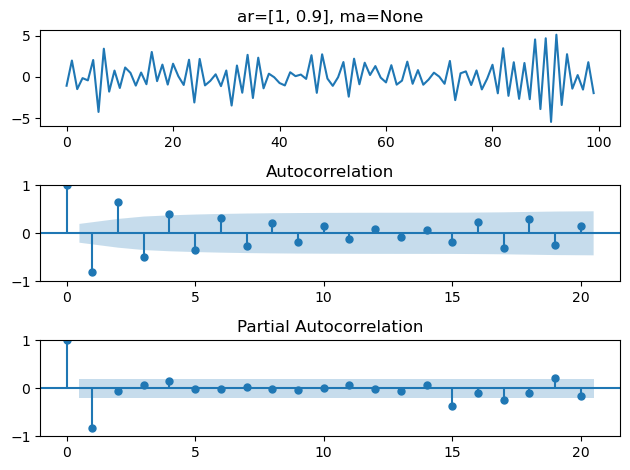

ARMA = [[1, -0.9], None]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -138.776
Date:                Mon, 31 Jul 2023   AIC                            283.553
Time:                        14:18:32   BIC                            291.368
Sample:                             0   HQIC                           286.716
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0229      0.588     -0.039      0.969      -1.176       1.130
ar.L1          0.8318      0.076     10.913      0.000       0.682       0.981
sigma2         0.9285     

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


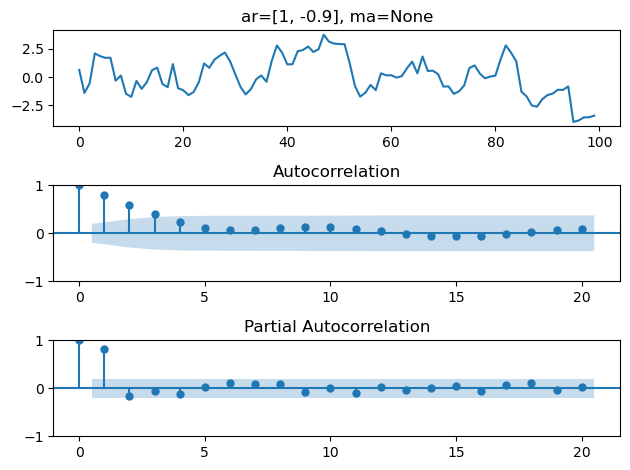

ARMA = [None, [1, 0.9]]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -139.020
Date:                Mon, 31 Jul 2023   AIC                            284.040
Time:                        14:18:33   BIC                            291.856
Sample:                             0   HQIC                           287.203
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1743      0.187     -0.934      0.350      -0.540       0.191
ma.L1          0.9091      0.043     21.211      0.000       0.825       0.993
sigma2         0.9277      

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


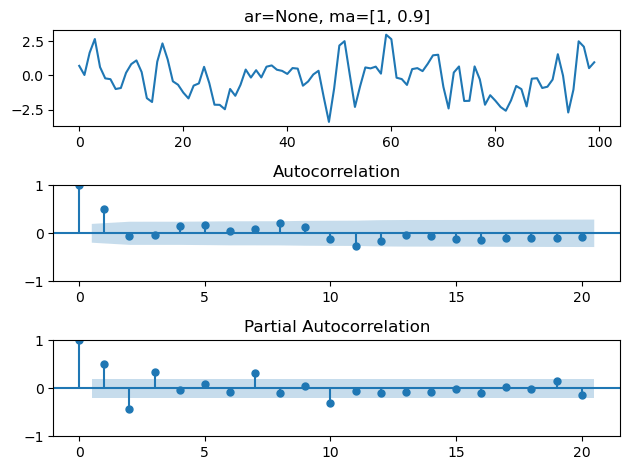

ARMA = [None, [1, -0.9]]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -126.592
Date:                Mon, 31 Jul 2023   AIC                            259.184
Time:                        14:18:34   BIC                            266.999
Sample:                             0   HQIC                           262.347
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0198      0.003     -6.379      0.000      -0.026      -0.014
ma.L1         -0.9999     25.990     -0.038      0.969     -51.940      49.940
sigma2         0.7032     

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


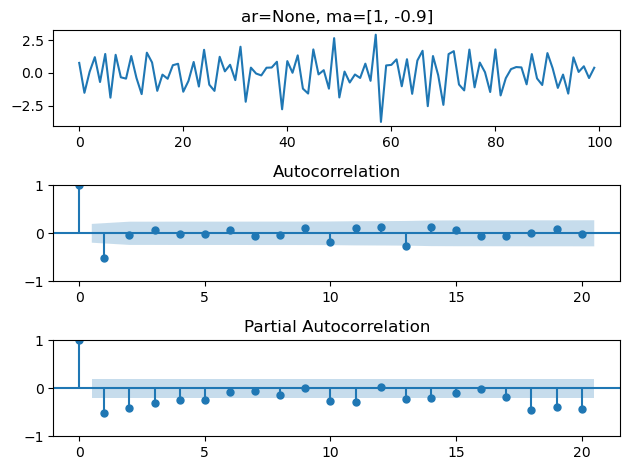

In [44]:
np.random.seed(123)
for arma in arma_list:
    ar = arma[0]
    ma = arma[1]
    
    # Datos
    arma_process = tsa.arima_process.ArmaProcess(ar, ma)
    y = arma_process.generate_sample(100)

    # Modelo
    print(f'ARMA = {arma}\n')
    
    if ar is None:
        model = ARIMA(y, order=(0,0,1)).fit()
    else:
        model = ARIMA(y, order=(1,0,0)).fit()
        
    print(model.summary())

    # Grafico datos, ACF y PACF
    fig, axs = plt.subplots(3,1)
    
    axs[0].plot(y)
    axs[0].set_title(f'ar={ar}, ma={ma}')
    
    plot_acf(y, ax=axs[1]);
    plot_pacf(y, ax=axs[2])
    plt.tight_layout()
    
    plt.show()

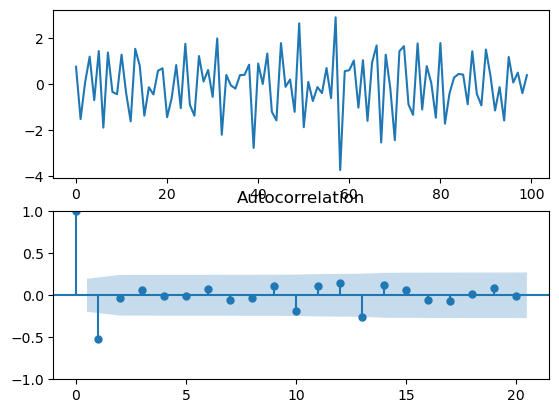

In [45]:
fig, axs = plt.subplots(2,1)

axs[0].plot(y)

plot_acf(y, ax=axs[1]);